<a href="https://colab.research.google.com/github/SergeyKamenshchikov/Sksummy/blob/master/WikiSumCorpus_parse_build_evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 show matplotlib

Name: matplotlib
Version: 3.2.2
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: matplotlib-users@python.org
License: PSF
Location: /usr/local/lib/python3.6/dist-packages
Requires: numpy, kiwisolver, python-dateutil, pyparsing, cycler
Required-by: yellowbrick, seaborn, scikit-image, pycocotools, plotnine, pandas-profiling, mlxtend, mizani, missingno, matplotlib-venn, keras-vis, imgaug, fbprophet, fastai, descartes, daft


**install if needed**

In [ ]:
!pip3 install sumy
!pip3 install rouge
!pip3 install xlsxwriter
!pip3 install xlrd
!pip3 install wikipedia-api
import nltk
nltk.download('punkt')

     |████████████████████████████████| 92kB 3.5MB/s 
     |████████████████████████████████| 10.1MB 6.9MB/s 
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21683 sha256=615c2d02b1f382a5ba17fbecfeeec11442c4af478608cb11ef62c1ed37d84288
  Stored in directory: /root/.cache/pip/wheels/5a/4d/a1/510b12c5e65e0b2b3ce539b2af66da0fc57571e528924f4a52
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746863 sha256=15f2b8031163a5229b819792d10ea2044973826454a051755986ca408dacd03b
  Stored in directory: /root/.cache/pip/wheels/33/4e/a6/be297e6b83567e537bed9df4a93f8590ec01c1acfbcd405348
Successfully built breadability pycountry
     |████████████████████████████████| 153kB 4.2MB/s 
  Created wheel for wikipedia-api: filename=Wikipedia_API-0.5.4-cp36-none-any.whl size=13462 sha256=00379d54dc1dc7cf737939da3e9b5d2910ad9bb19288c42cbaa6d2c4924a3963
  Stored in directory: /root/.cache/pip/wheels/bf/40/42/ba1d497f3712281b659dd65b566

True

**import modules**

In [ ]:
#summarization
from sumy.parsers.html import HtmlParser
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words

#utils
from nltk.tokenize import sent_tokenize
import pandas
import random
import numpy
import time
import random

#evaluation
from rouge import Rouge
rouge = Rouge()

#visualization
import matplotlib.pyplot as plt

#wiki
import wikipediaapi
wiki_wiki = wikipediaapi.Wikipedia('en')

**Load** **models**

In [ ]:
stemmer = Stemmer("english")

#LSA summarizer
lsa_summarizer = LsaSummarizer(stemmer)
lsa_summarizer.stop_words=get_stop_words("english")

#TEXTRANK summarizer
tr_summarizer = TextRankSummarizer(stemmer) 
tr_summarizer.stop_words=get_stop_words("english")

**Functions**

In [ ]:
#get summary via LSA
def get_summary_lsa(rawtext, num_of_sentences):
    sentences = num_of_sentences #target size of summary

    parser = PlaintextParser.from_string(rawtext, Tokenizer("english"))

    text_list = []
    for sentence in lsa_summarizer(parser.document, sentences):
        text_list.append(str(sentence))
    txt =' '.join(text_list)

    return(txt)

#get summary via TR
def get_summary_textrank(rawtext, num_of_sentences):
    sentences = num_of_sentences #target size of summary

    parser = PlaintextParser.from_string(rawtext), Tokenizer("english"))

    text_list = []
    for sentence in tr_summarizer(parser.document, sentences):
        text_list.append(str(sentence))
    txt =' '.join(text_list)

    return(txt)

#get summary via random
def get_summary_random(rawtext,target_num_of_sentences):
    sentences=sent_tokenize(rawtext)
    n_sentences=len(sentences)
    if target_num_of_sentences >= n_sentences:
        return(rawtext)
    random_sentences=random.sample(sentences,target_num_of_sentences)
    return(' '.join(random_sentences))

#get rouge2 f-score 
def get_rouge_2_f(text1,text2):
    scores = rouge.get_scores(text1, text2)
    score_f=scores[0]['rouge-2']['f']
    return(score_f)


def evaluate(texts,summary_function,sent_n_values):
    
    rouge_2f_median_scores=[]
    rouge_2f_deviation_values=[]

    for sent_n in sent_n_values:
        print('Evaluating for', sent_n,'sentences...')
        
        rouge_2f_scores=[]
        i=0
        for text in texts:
            #preprocess
            text=text.replace('\n',' ')


            summary=summary_function(text,sent_n)
            
            try:
                score_r2f=get_rouge_2_f(summary,text)
                rouge_2f_scores.append(score_r2f)
            except:
                print('Error when parsing')
            
            i=i+1
            if i%200==0:
                print(round(i/len(texts)*100,2),'%  done')

        rouge_2f_median_scores.append(round(numpy.median(rouge_2f_scores),2))
        rouge_2f_deviation_values.append(round(numpy.std(rouge_2f_scores),2))
        
        print(rouge_2f_median_scores)
        print(rouge_2f_deviation_values)
        
    return rouge_2f_median_scores,rouge_2f_deviation_values

def get_all_pages_down_category_tree(catmembers,output,level,levels_limit):
  if level<=levels_limit:

    for k in catmembers:
      if catmembers[k].ns==0 and k not in output:
        output.append(k)

      if catmembers[k].ns==14 and k not in output:
          cat = wiki_wiki.page(k)
          print(cat)
          output.append(k)
          get_all_pages_down_category_tree(cat.categorymembers,output,level+1,levels_limit)
        
  if level>levels_limit:
    return

def extract_wiki_text(urlname):
  
  #get page by name
  page_py = wiki_wiki.article(title=urlname)

  #check if article
  if not page_py.exists():
    print('ERROR: not found ', urlname)
    return ''

  #get full text
  article_text=page_py.text

  return article_text

**Collect** **articles from categories**

In [ ]:
%%time
cat = wiki_wiki.page("Category:Artificial_intelligence")
ai_pages=["Category:Artificial_intelligence"]
get_all_pages_down_category_tree(cat.categorymembers,ai_pages,0,2)

ai_articles=[page for page in ai_pages if page[:9]!='Category:'] #delete category pages
print('Number of articles:',len(ai_articles))

ai_articles_text=[extract_wiki_text(page) for page in ai_articles] #collect text for articles
print('Articles collected:', len(ai_articles_text))

In [ ]:
%%time
cat = wiki_wiki.page("Category:Medicine")
md_pages=["Category:Medicine"]
get_all_pages_down_category_tree(cat.categorymembers,md_pages,0,2)

md_articles=[page for page in md_pages if page[:9]!='Category:']
print('Number of articles:',len(md_articles))

md_articles_text=[extract_wiki_text(page) for page in md_articles]
print('Articles collected:', len(md_articles_text))

In [ ]:
%%time
cat = wiki_wiki.page("Category:Chemistry")
ce_pages=["Category:Chemistry"]
get_all_pages_down_category_tree(cat.categorymembers,ce_pages,0,2)

ce_articles=[page for page in ce_pages if page[:9]!='Category:']
print('Number of articles:',len(ce_articles))

ce_articles_text=[extract_wiki_text(page) for page in ce_articles]
print('Articles collected:', len(ce_articles_text))

In [ ]:
%%time
cat = wiki_wiki.page("Category:Physics")
tp_pages=["Category:Physics"]
get_all_pages_down_category_tree(cat.categorymembers,tp_pages,0,2)

tp_articles=[page for page in tp_pages if page[:9]!='Category:']
print('Number of articles:',len(tp_articles))

tp_articles_text=[extract_wiki_text(page) for page in tp_articles]
print('Articles collected:', len(tp_articles_text))

**Count number of articles of desired size**

In [ ]:
target_length = 50

target_ai_articles_text=[ text for text in ai_articles_text if len(sent_tokenize(text))>target_length-1]
target_md_articles_text=[ text for text in md_articles_text if len(sent_tokenize(text))>target_length-1]
target_ce_articles_text=[ text for text in ce_articles_text if len(sent_tokenize(text))>target_length-1]
target_tp_articles_text=[ text for text in tp_articles_text if len(sent_tokenize(text))>target_length-1]

print('Num of articles of desired length:',len(target_ai_articles_text))
print('Num of articles of desired length:',len(target_md_articles_text))
print('Num of articles of desired length:',len(target_ce_articles_text))
print('Num of articles of desired length:',len(target_tp_articles_text))

Num of articles of desired length: 1907
Num of articles of desired length: 2115
Num of articles of desired length: 3968
Num of articles of desired length: 2411


**make categories balanced**

In [ ]:
num_of_articles=1907

balanced_target_ai_articles_text=random.sample(target_ai_articles_text,num_of_articles)
balanced_target_md_articles_text=random.sample(target_md_articles_text,num_of_articles)
balanced_target_ce_articles_text=random.sample(target_ce_articles_text,num_of_articles)
balanced_target_tp_articles_text=random.sample(target_tp_articles_text,num_of_articles)

print(len(balanced_target_ai_articles_text))
print(len(balanced_target_md_articles_text))
print(len(balanced_target_ce_articles_text))
print(len(balanced_target_tp_articles_text))

1907
1907
1907
1907


**Normalize articles length**

In [ ]:
cut_balanced_target_ai_articles_text=[' '.join(sent_tokenize(text)[:target_length]) for text in balanced_target_ai_articles_text]
cut_balanced_target_md_articles_text=[' '.join(sent_tokenize(text)[:target_length]) for text in balanced_target_md_articles_text]
cut_balanced_target_ce_articles_text=[' '.join(sent_tokenize(text)[:target_length]) for text in balanced_target_ce_articles_text]
cut_balanced_target_tp_articles_text=[' '.join(sent_tokenize(text)[:target_length]) for text in balanced_target_tp_articles_text]

**Save corpus**

In [ ]:
corpus_texts=cut_balanced_target_ai_articles_text+cut_balanced_target_md_articles_text+cut_balanced_target_ce_articles_text+cut_balanced_target_tp_articles_text
corpus_texts=set(corpus_texts)
print('Corpus size:',len(corpus_texts))

Corpus size: 7232


In [ ]:
new_list = corpus_texts
df = pandas.DataFrame(new_list)
writer = pandas.ExcelWriter('domain_corpus_7000_50.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='corpus', index=False)
writer.save()

**Load corpus**

In [ ]:
df = pandas.read_excel('/content/domain_corpus_7000_50.xlsx')
corpus_texts=df[0].tolist()
corpus_texts=[str(text) for text in corpus_texts]
df

,0
0,Foot Clan is a fictional ninja clan in the Tee...
1,Paul Jorion (born 22 July 1946 in Brussels) is...
2,Perfusion is the passage of fluid through the ...
3,Biomedical waste or hospital waste is any kind...
4,ASCII stereograms are a form of ASCII art base...
...,...
7227,Oak Ridge National Laboratory (abbreviated as ...
7228,A Life Model Decoy (frequently known by the ab...
7229,The study of interdependent networks is a subf...
7230,"Brass is an alloy of copper and zinc, in propo..."


**Evaluate**

In [ ]:
#points for evaluation
target_length=50
cut=target_length
sent_n_values= list(range(int(cut*0.1),cut,int(cut*0.1))) + [cut]
print(sent_n_values)

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50]


In [ ]:

#evaluated
random_method_r2f=[0.17, 0.32, 0.44, 0.55, 0.64, 0.72, 0.79, 0.86, 0.91,1.0]
random_method_deviation =[0.05, 0.05, 0.06, 0.06, 0.06, 0.05, 0.05, 0.04, 0.04,0.04]

textrank_method_r2f=[0.3, 0.47, 0.59, 0.69, 0.76, 0.83, 0.88, 0.93, 0.97, 1.0]
textrank_method_deviation=[0.08, 0.08, 0.07, 0.06, 0.05, 0.05, 0.04, 0.04, 0.04, 0.04]

lsa_method_r2f =[0.23, 0.4, 0.53, 0.63, 0.73, 0.8,0.87, 0.93, 0.97, 1.0]
lsa_method_deviation=[0.06, 0.07, 0.07, 0.07, 0.06, 0.05,0.04, 0.03, 0.02, 0.0]


In [ ]:
random_method_r2f, random_method_deviation = evaluate(corpus_texts,get_summary_random,[5])

In [ ]:
%%time
textrank_method_r2f, textrank_method_deviation = evaluate(corpus_texts,get_summary_textrank,[5])

In [ ]:
%time
lsa_method_r2f, lsa_method_deviation = evaluate(corpus_texts,get_summary_lsa,[45, 50])

**print graph**

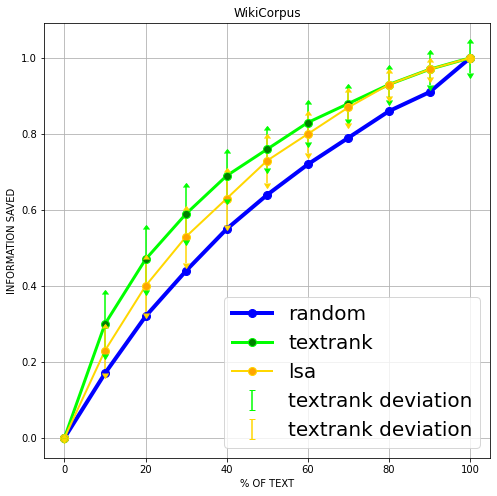

In [ ]:
# Data


df=pandas.DataFrame({
    'N_sent': [0]+[10,20,30,40,50,60,70,80,90,100],
    'random': [0]+random_method_r2f,
    'textrank':[0]+textrank_method_r2f,'textrank_deviation':[0]+textrank_method_deviation ,
    'lsa':[0]+lsa_method_r2f ,'lsa_deviation': [0]+lsa_method_deviation
    })
 
plt.figure(figsize=(8,8)) 
# multiple line plot
plt.plot( 'N_sent', 'random', data=df, marker='o', markerfacecolor='blue', markersize=8, color='blue', linewidth=4)
plt.plot( 'N_sent', 'textrank', data=df, marker='o',markerfacecolor='green', markersize=8, color='lime', linewidth=3)
plt.plot( 'N_sent', 'lsa', data=df, marker='o',markerfacecolor='orange', markersize=8, color='gold', linewidth=2)
plt.errorbar('N_sent', 'textrank','textrank_deviation',data=df, linestyle='None',color='lime',uplims=True, lolims=True,label='textrank deviation')
plt.errorbar('N_sent', 'lsa','lsa_deviation',data=df, linestyle='None',color='gold',uplims=True, lolims=True,label='textrank deviation')
plt.legend(prop={'size': 20})
plt.ylabel("INFORMATION SAVED")
plt.xlabel('% OF TEXT')
plt.title('WikiCorpus')
plt.grid()
plt.show()